# LSTM model for prediction in weather and prices

## Part 1: Data Analysis and new variables construction

In [72]:
# importing libraries
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

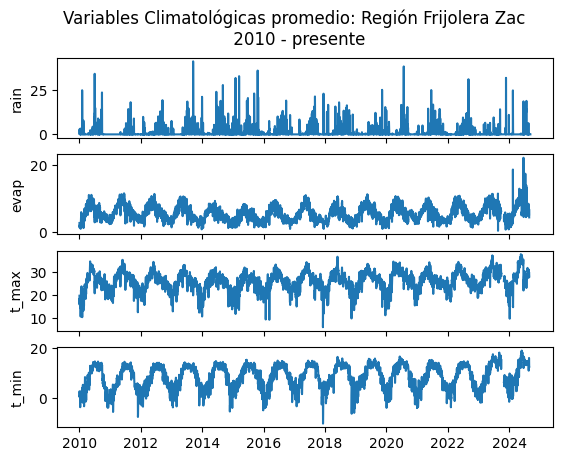

In [73]:
# Data Collection

bayo_prices = pd.read_csv('prices_data/bayo_clean_data.csv',index_col='date')
bayo_prices.index = pd.to_datetime(bayo_prices.index)

weather_zac = pd.read_csv('weather_data/zac_region_frij.csv',index_col='date')
weather_zac.index = pd.to_datetime(weather_zac.index)
weather_zac.drop(columns=['year','month'], inplace=True)

f, ax = plt.subplots(4,1, sharex=True)
for i in range(4):
    ax[i].plot(weather_zac.loc['2010-01-01':].index.values,
                weather_zac[weather_zac.columns[i]].loc['2010-01-01':].values)
    ax[i].set_ylabel(weather_zac.columns[i])

a1 = f.suptitle('Variables Climatológicas promedio: Región Frijolera Zac \n 2010 - presente')

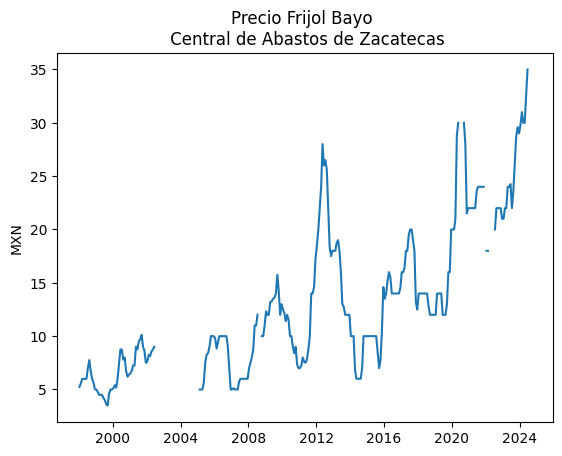

In [74]:
f, ax = plt.subplots()
ax.plot(bayo_prices.index, bayo_prices.values)
ax.set_ylabel('MXN')
a2 = ax.set_title('Precio Frijol Bayo \n Central de Abastos de Zacatecas')

In [75]:
# to know the inital time of measures of prices of bean : 1998-01-15
bayo_prices.head()

,price
date,
1998-01-15,5.25
1998-02-15,5.58
1998-03-15,6.00
1998-04-15,6.00
1998-05-15,6.00


In [76]:
bayo_data = weather_zac.loc['1998-01-15':].join(bayo_prices)
print(bayo_data.info())
bayo_data.tail(20)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9726 entries, 1998-01-15 to 2024-09-12
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   rain    9725 non-null   float64
 1   evap    9688 non-null   float64
 2   t_max   9695 non-null   float64
 3   t_min   9695 non-null   float64
 4   price   278 non-null    float64
dtypes: float64(5)
memory usage: 455.9 KB
None


,rain,evap,t_max,t_min,price
date,,,,,
2024-08-12,0.0000,6.892500,30.400000,14.500000,NaN
2024-08-13,0.0000,6.317500,30.060000,14.740000,NaN
2024-08-14,0.3200,8.227500,29.920000,14.440000,NaN
2024-08-15,0.0000,6.017500,29.900000,14.740000,30.0
2024-08-16,0.0000,7.447500,30.600000,14.300000,NaN
2024-08-17,0.0000,6.667500,30.120000,14.380000,NaN
2024-08-18,1.9020,7.452500,29.340000,13.300000,NaN
2024-08-19,6.3600,8.566667,30.140000,14.840000,NaN
2024-08-20,0.0000,5.337500,27.425000,14.900000,NaN


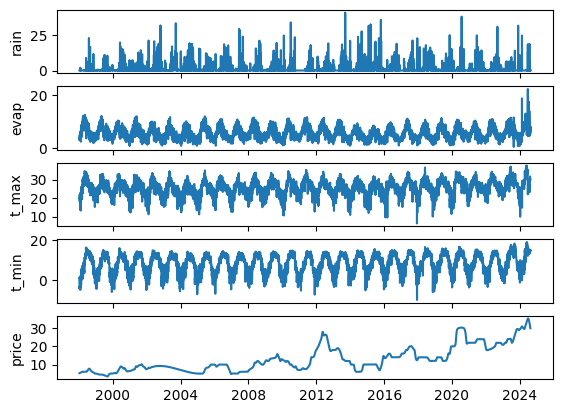

In [77]:
filled_data = bayo_data[['rain','evap','t_max','t_min']].loc[:'2024-08-15'].interpolate(method='time')
filled_data['price']  = bayo_data['price'].interpolate(method='akima')

f, ax = plt.subplots(5,1, sharex=True)
for i in range(5):
    ax[i].plot(filled_data.index.values,
                filled_data[filled_data.columns[i]].values)
    ax[i].set_ylabel(filled_data.columns[i])

Al parecer no hay datos suficientes para predecir los precios del frijol

<Axes: >

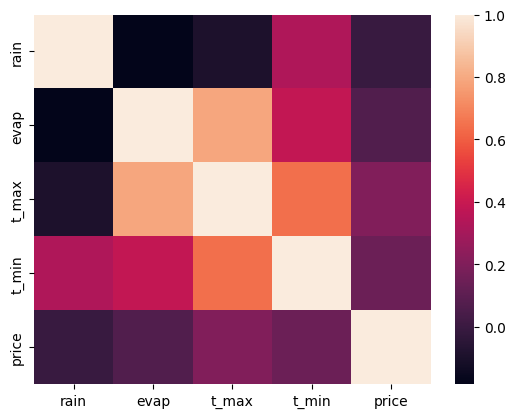

In [78]:
sns.heatmap(bayo_data.corr())

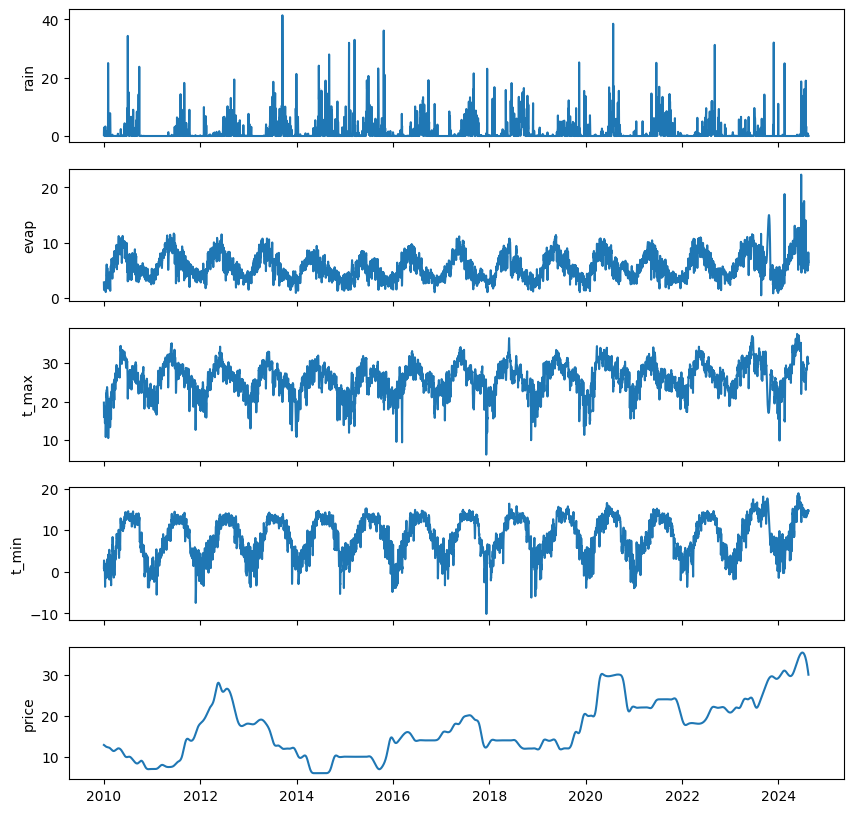

In [79]:
augmented_bayo_data = bayo_data.loc[:'2024-08-15']

augmented_bayo_data = augmented_bayo_data.interpolate(method='cubic')

num_cols = len(augmented_bayo_data.columns)

f, ax = plt.subplots(num_cols,1, sharex=True, figsize = (10, 10))
for i in range(num_cols):
    ax[i].plot(augmented_bayo_data.loc['2010-01-01':].index.values,
                augmented_bayo_data[augmented_bayo_data.columns[i]].loc['2010-01-01':].values)
    ax[i].set_ylabel(augmented_bayo_data.columns[i])


In [80]:
price_corr = augmented_bayo_data.corr()['price']
price_corr

rain     0.004190
evap     0.100592
t_max    0.199417
t_min    0.179937
price    1.000000
Name: price, dtype: float64

<Axes: >

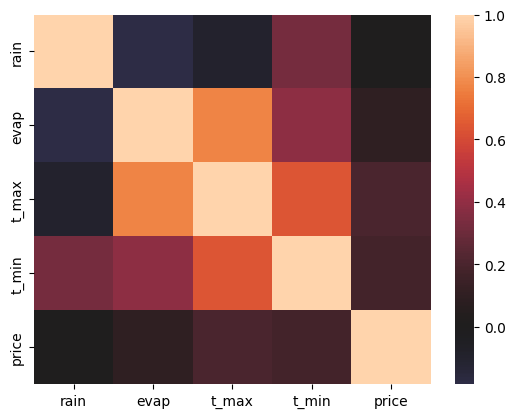

In [81]:
sns.heatmap(augmented_bayo_data.corr(), center=0)

## Part 2: Data preprocessing

In [82]:
# to check if the date ranges are ok
fecha_inicio = augmented_bayo_data.index.min()
fecha_fin = augmented_bayo_data.index.max()
rango_completo = pd.date_range(start=fecha_inicio, end=fecha_fin, freq='D')

fechas_presentes = augmented_bayo_data.index
fechas_faltantes = rango_completo[~rango_completo.isin(fechas_presentes)]

# Cuenta las fechas faltantes
num_fechas_faltantes = len(fechas_faltantes)
print(f"Número de fechas faltantes: {num_fechas_faltantes}")

# Si deseas ver las fechas faltantes específicas:
print(f'Fecha inicio: {fecha_inicio}, fecha fin: {fecha_fin}')
print("Fechas faltantes:")
print(fechas_faltantes)

Número de fechas faltantes: 0
Fecha inicio: 1998-01-15 00:00:00, fecha fin: 2024-08-15 00:00:00
Fechas faltantes:
DatetimeIndex([], dtype='datetime64[ns]', freq='D')


In [83]:
split_fraction = 0.75
train_split =  int(split_fraction * int(augmented_bayo_data.shape[0]))

def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    # print('data mean:', data_mean)
    # print('data std', data_std)
    print(f'Scale factor = (data) * {data_std['price']} + {data_mean['price']}')
    return (data - data_mean) / data_std

train_split

7282

In [84]:
features = augmented_bayo_data
# features.index = features.index.

features = normalize(features, train_split)
features = pd.DataFrame(features)

train_data = features.iloc[0: train_split -1]
test_data = features.iloc[train_split:]

features.shape

Scale factor = (data) * 4.6414651689814805 + 10.107023653386548


(9710, 5)

In [85]:
x_train = train_data.values
y_train = train_data['price'].values

## Part 3: Model Development and predictions

In [86]:
sequence_length = 5 # 15 days per tensor
batch_size = 120
learning_rate = 0.001

import keras
dataset_train = keras.utils.timeseries_dataset_from_array(
    data=x_train,
    targets=y_train,
    sequence_length=sequence_length,
    batch_size=batch_size,
    seed=34
)

x_test = test_data.values
y_test = test_data['price'].values

dataset_test = keras.utils.timeseries_dataset_from_array(
    data = x_test,
    targets=y_test,
    sequence_length=sequence_length,
    batch_size=batch_size,
    seed = 43
)

for batch in dataset_train.take(1):
    inputs, targets = batch

print('Input shape:',inputs.numpy().shape)
print('Target shape:', targets.numpy().shape)



Input shape: (120, 5, 5)
Target shape: (120,)


In [87]:
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 5, 5)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 32)             │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,897 (19.13 KB)

 Trainable params: 4,897 (19.13 KB)

 Non-trainable params: 0 (0.00 B)

In [88]:
path_checkpoint = 'model_checkpoint.weights.h5'
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor='val_loss',
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True
)

###### Fitting the model
epochs = 40

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_test,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/40
56/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5409
Epoch 1: val_loss improved from inf to 2.81441, saving model to model_checkpoint.weights.h5
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.5436 - val_loss: 2.8144
Epoch 2/40
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0899
Epoch 2: val_loss improved from 2.81441 to 0.87590, saving model to model_checkpoint.weights.h5
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0904 - val_loss: 0.8759
Epoch 3/40
54/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0162
Epoch 3: val_loss improved from 0.87590 to 0.55707, saving model to model_checkpoint.weights.h5
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0182 - val_loss: 0.5571
Epoch 4/40
52/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0143
Epoch 4: val_loss improved from 0.55707 to 0.44349, saving model to model_checkpoint.weights.h5
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0160 - val_loss: 0.4435
Epoch 5/40
57/61 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0146

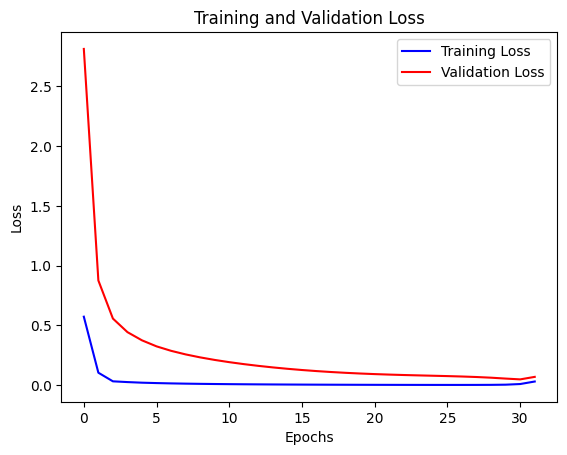

In [89]:
def visualize_loss(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

visualize_loss(history, 'Training and Validation Loss')

In [90]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return


In [91]:
prediction = model.predict(dataset_test)

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


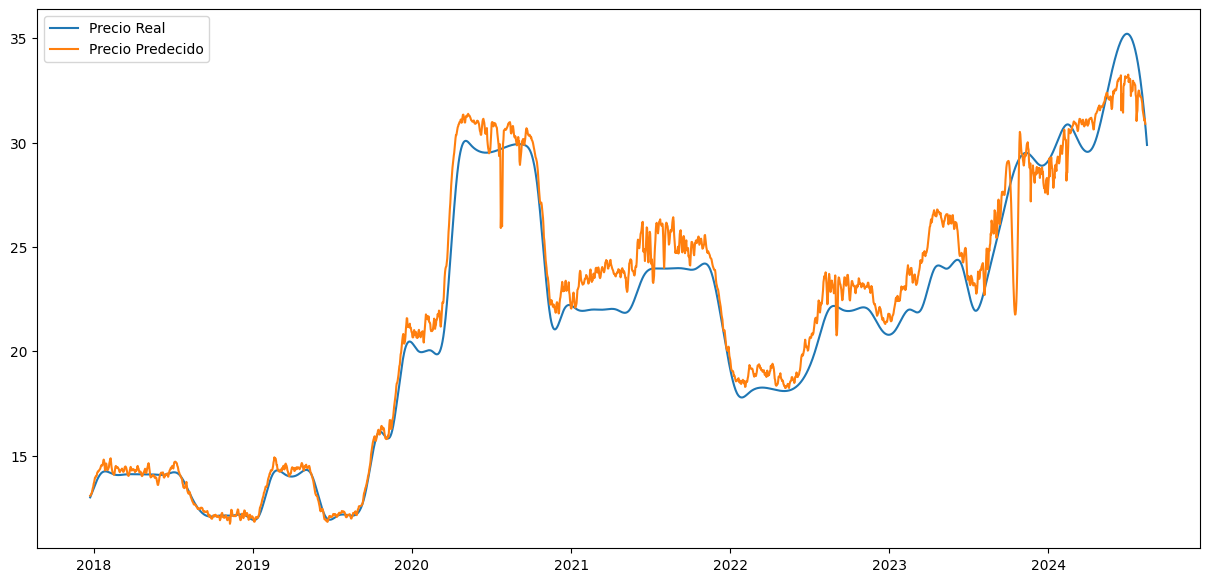

In [92]:
predictions = prediction.flatten()
count_pred = len(predictions)

#(data + 10.05598903566464) * 4.654588743043078

plt.figure(figsize=(15,7))
plt.plot(test_data['price'].index, test_data['price'] * 4.578850218807721 + 10.257168845442097, label = 'Precio Real')
plt.plot(test_data.iloc[:count_pred].index, predictions * 4.578850218807721 + 10.257168845442097, label = 'Precio Predecido')
plt.legend()

In [93]:
Val_Loss = round(history.history['val_loss'][-1], 2)
model.save(f'models/simple_1_{epochs}_{learning_rate}_{sequence_length}_{Val_Loss}.keras')

with open(f'models/simple_1_{epochs}_{learning_rate}_{sequence_length}_{Val_Loss}.txt', 'w') as cols_file:
    cols_file.write(f'For model simple_1_{epochs}_{learning_rate}_{sequence_length}_{Val_Loss} \n')
    cols_file.write(f'With Params: epochs {epochs}, learning rate {learning_rate}, sequence lenght {sequence_length} \n')
    cols_file.write(f'Has losses: Loss {history.history['loss'][-1]}, Validation Loss {Val_Loss} \n')
    cols_file.write(str(features.columns.values))